In [2]:
import pandas as pd
import gpplot
import seaborn as sns
from scipy import stats
import plotnine as gg
import matplotlib.pyplot as plt
from poola import core as pool
import seaborn as sns
import gpplot

In [3]:
def count_elements(seq):
    seqs = {}
    for i in seq:
        seqs[i] = seqs.get(i, 0) + 1
        
    return seqs

In [4]:
gilbert_data = pd.read_excel('../data/gilbert_2014/NIHMS630425-supplement-10.xlsx', sheet_name = 0)

/Users/fzheng/opt/anaconda3/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed


In [5]:
essential_genes = pd.read_table('https://raw.githubusercontent.com/gpp-rnd/genesets/master/human/essential-genes-Hart2015.txt',
                            names=['GENE'])
nonessential_genes = pd.read_table('https://raw.githubusercontent.com/gpp-rnd/genesets/master/human/non-essential-genes-Hart2014.txt',
                                   names=['GENE'])

In [6]:
#all_designs = pd.read_table('/Volumes/GoogleDrive/Shared drives/GPP Cloud /R&D/People/Fengyi/gpp-annotation-files/sgRNA_design_9606_GRCh38_SpyoCas9_CRISPRi_RS3seq-Chen2013_Ensembl_20220808.txt.gz')

all_designs = pd.read_table('../../../gpp-annotation-files/sgRNA_design_9606_GRCh38_SpyoCas9_CRISPRi_RS3seq-Chen2013_Ensembl_20220808.txt.gz')


In [7]:
gilbert_data['gene'] = gilbert_data['sgRNA ID'].str.split('-', expand=True)[0]
gilbert_data = gilbert_data[['gene', 'Protospacer sequence', 'Growth phenotype (gamma)','CTx-DTA phenotype (rho)']]

In [8]:
len_seq = [len(seq) for seq in gilbert_data['Protospacer sequence']]
counted = count_elements(len_seq)
counted

{21: 105030,
 20: 48601,
 22: 21461,
 19: 15401,
 25: 2198,
 18: 3476,
 23: 6858,
 24: 3394,
 2: 1,
 7: 1}

# Standardize sequence length

In [9]:
new_seqs = [seq if len(seq) < 20 else seq[len(seq) - 20:len(seq)] for seq in gilbert_data['Protospacer sequence']]
gilbert_data['20mer_less'] = new_seqs

In [10]:
mask = gilbert_data['20mer_less'].str.len() == 19
gilbert_data_19 = gilbert_data.loc[mask]
mask = gilbert_data['20mer_less'].str.len() == 18
gilbert_data_18 = gilbert_data.loc[mask]

sg_list = list(gilbert_data_19['20mer_less'].unique())
all_designs['19mer'] = all_designs['sgRNA Sequence'].str[1:]
design_df_19 = (all_designs[all_designs['19mer'].isin(sg_list)]
             .reset_index(drop=True))

sg_list = list(gilbert_data_18['20mer_less'].unique())
all_designs['18mer'] = all_designs['sgRNA Sequence'].str[2:]
design_df_18 = (all_designs[all_designs['18mer'].isin(sg_list)]
             .reset_index(drop=True))

In [11]:
design_df_18.columns

Index(['Input', 'Quota', 'Target Taxon', 'Target Gene ID',
       'Target Gene Symbol', 'Target Alias', 'CRISPR Mechanism',
       'Target Domain', 'Reference Sequence', 'Strand of Target',
       'TSS Position', 'PAM Policy', 'Off-Target Match Ruleset Version',
       'Off-Target Tier Policy', 'Off-Target Match Bin Policy',
       'Strand of sgRNA', 'Orientation', 'sgRNA 'Cut' Position',
       'sgRNA Sequence', 'sgRNA Context Sequence', 'PAM Sequence',
       'sgRNA 'Cut' Site TSS Offset', 'Other Target Matches',
       '# Off-Target Tier I Match Bin I Matches',
       '# Off-Target Tier II Match Bin I Matches',
       '# Off-Target Tier III Match Bin I Matches',
       '# Off-Target Tier I Match Bin II Matches',
       '# Off-Target Tier II Match Bin II Matches',
       '# Off-Target Tier III Match Bin II Matches',
       '# Off-Target Tier I Match Bin III Matches',
       '# Off-Target Tier II Match Bin III Matches',
       '# Off-Target Tier III Match Bin III Matches',
       '# O

In [12]:
design_cols = ['sgRNA Sequence', 'sgRNA Context Sequence', 'Target Gene Symbol', "sgRNA 'Cut' Site TSS Offset", 'On-Target Efficacy Score','DHS Score','Off-Target Rank','Pick Order']

In [13]:
lfcs_designs_19 = (gilbert_data_19.rename({'20mer_less': '19mer',
                                          'gene': 'Target Gene Symbol'}, axis=1)
                .merge(design_df_19[design_cols + ['19mer', '# Off-Target Tier I Match Bin I Matches']], how='inner',
                       on=['19mer','Target Gene Symbol'])
                .drop('19mer', axis=1))
lfcs_designs_18 = (gilbert_data_18.rename({'20mer_less': '18mer',
                                          'gene': 'Target Gene Symbol'}, axis=1)
                .merge(design_df_18[design_cols + ['18mer', '# Off-Target Tier I Match Bin I Matches']], how='inner',
                       on=['18mer', 'Target Gene Symbol'])
                .drop('18mer', axis=1))
lfcs_designs_20 = (gilbert_data.rename({'20mer_less': 'sgRNA Sequence',
                                          'gene': 'Target Gene Symbol'}, axis=1)
                .merge(all_designs[design_cols + ['# Off-Target Tier I Match Bin I Matches']], how='inner',
                       on=['sgRNA Sequence','Target Gene Symbol']))
gilbert_lfcs_designs = pd.concat([lfcs_designs_18, lfcs_designs_19, lfcs_designs_20])

# ROC-AUC

In [14]:
gilbert_lfcs_designs['condition'] = 'K562'
roc_aucs, _ = pool.get_roc_aucs(lfcs=gilbert_lfcs_designs, tp_genes=essential_genes.GENE,
                                fp_genes=nonessential_genes.GENE, gene_col='Target Gene Symbol',
                                score_col='Growth phenotype (gamma)', condition_col='condition')
roc_aucs.sort_values('ROC-AUC')

,condition,ROC-AUC
0,K562,0.731471


In [15]:
gilbert_lfcs_designs['sgRNA Context Sequence'].value_counts()

GAGTGAGTCGTCCTCCATGTCGACTGGAAC    8
TTGTGATCCTCGTTCCAGTCGACATGGAGG    8
GTCGACACGGGTCTCACATGAGAGTGGTGA    8
ACTGCAAGGAAGCGTTCACGTAGCAGGTAT    8
GGAGGACGACTCACTCTACTTGAGAGGTGA    8
                                 ..
ACCGGGCAGGTTGCTTGAAGCGCAGGGGTT    1
CCGCGGAAGGGTCTATGGCCGAGGCGGTGA    1
GTGGTGGGATCAAATATTGGAAGGTGGAGG    1
GCCCGACCTGGCGGCCCCGCCTCTCGGCCC    1
CAGTGAAGACGAAGCGGCAGCTGCCGGTGG    1
Name: sgRNA Context Sequence, Length: 103861, dtype: int64

# Compare different normalization techniques

In [16]:
relevant_sgs_designs = gilbert_lfcs_designs[gilbert_lfcs_designs['Target Gene Symbol'].isin(essential_genes.GENE)]
filtered_sgs = relevant_sgs_designs[relevant_sgs_designs['# Off-Target Tier I Match Bin I Matches'] == '0'].copy()
filtered_sgs['Protospacer sequence length'] = [len(seq) for seq in filtered_sgs['Protospacer sequence']]


In [17]:
sgrna_context_dup = filtered_sgs[filtered_sgs.duplicated('sgRNA Context Sequence', keep=False) == True]
len(sgrna_context_dup)

494

In [18]:
sgrna_context_dup = sgrna_context_dup.drop_duplicates(subset=['Protospacer sequence'], keep = False)
len(sgrna_context_dup)

494

In [19]:

keep_20 = sgrna_context_dup.loc[sgrna_context_dup['Protospacer sequence length']==20] # keep those seq


In [20]:
sgrna_context_dup_re = sgrna_context_dup[~sgrna_context_dup['sgRNA Context Sequence'].isin(keep_20['sgRNA Context Sequence'])]


In [21]:
sgrna_context_dup['Protospacer sequence length'].value_counts()

20    194
21    185
19     95
18     19
25      1
Name: Protospacer sequence length, dtype: int64

In [22]:
seq_remove = []
for seq in keep_20['sgRNA Context Sequence']:
    seq_df = filtered_sgs[filtered_sgs['sgRNA Context Sequence'] == seq]
    seq_remove.extend(seq_df.loc[seq_df['Protospacer sequence length'] != 20]['Protospacer sequence'].tolist())
for dup_seq in set(sgrna_context_dup_re['sgRNA Context Sequence'].tolist()):
    seq_df = filtered_sgs[filtered_sgs['sgRNA Context Sequence'] == dup_seq]
    if len(seq_df.loc[seq_df['Protospacer sequence length']==25]) ==1:
        seq_remove.extend(seq_df.loc[seq_df['Protospacer sequence length']==25]['Protospacer sequence'].tolist())
    else:
        seq_remove.extend(seq_df.loc[seq_df['Protospacer sequence length'] == seq_df['Protospacer sequence length'].min()]['Protospacer sequence'].tolist())
        
        
        

In [23]:
filtered_sgs = filtered_sgs[~filtered_sgs['Protospacer sequence'].isin(seq_remove)]

In [24]:
filtered_sgs['sgRNA Context Sequence'].value_counts()

GCTTGCGCCGCATGGAGTCCGAATCGGAAA    1
CGGTGTGTGCCGGGCGGTGACACGTGGACG    1
CCTGCGTCACGTCCGGCCCGTGAGTGGCGC    1
ACGGCGCTGCGCAGGCGCCACTCACGGGCC    1
CCGGACGTGACGCAGGGAAAGTTCCGGCTT    1
                                 ..
ACAGTAACGTCAGTGCTCGGAATTGGGCCC    1
ACAGGGTCCTTGGCCACAGTAAAGAGGAGG    1
CGGGATGGTGAGTTTCAGAGTTAGGGGTAT    1
CGCGGTTATACTTAATCTGCGTAATGGACC    1
TTTTGGGCAGCGTATTTTTGGAGGTGGAAT    1
Name: sgRNA Context Sequence, Length: 11122, dtype: int64

In [29]:
filtered_sgs['gene_mean_centered'] = (filtered_sgs.groupby(['Target Gene Symbol', 'condition'])['Growth phenotype (gamma)']
                                      .transform(lambda x: -(x - x.mean())))
filtered_sgs['gene_rank'] = (filtered_sgs.groupby(['Target Gene Symbol', 'condition'])['Growth phenotype (gamma)']
                             .rank(pct=True, ascending=False))

filtered_sgs['gene_zscore'] = (filtered_sgs.groupby(['Target Gene Symbol', 'condition'])['Growth phenotype (gamma)']
                               .transform(lambda x: -(x - x.mean())/x.std()))
filtered_sgs['gene_median_centered'] = (filtered_sgs.groupby(['Target Gene Symbol', 'condition'])['Growth phenotype (gamma)']
                                        .transform(lambda x: -(x - x.median())))
filtered_sgs['gene_robust_zscore'] = (filtered_sgs.groupby(['Target Gene Symbol', 'condition'])['Growth phenotype (gamma)']
                                      .transform(lambda x: -(x - x.median())/(x.quantile(0.75) - x.quantile(0.25))))

sg_avg_rank = (filtered_sgs.groupby(['sgRNA Sequence', 'sgRNA Context Sequence', 'Target Gene Symbol', 
                                      'On-Target Efficacy Score', 'sgRNA \'Cut\' Site TSS Offset',
                                    'DHS Score','Off-Target Rank','Pick Order'])
               .agg(avg_rank = ('gene_rank', 'mean'),
                    avg_mean_centered_neg_gamma = ('gene_mean_centered', 'mean'),
                    avg_zscore_neg_gamma = ('gene_zscore', 'mean'),
                    avg_median_centered_neg_gamma = ('gene_median_centered', 'mean'),
                    avg_robust_zscore_neg_gamma = ('gene_robust_zscore', 'mean'),
                    avg_gamma = ('Growth phenotype (gamma)', 'mean'))
               .reset_index())

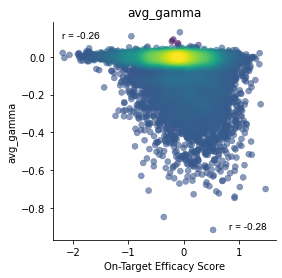

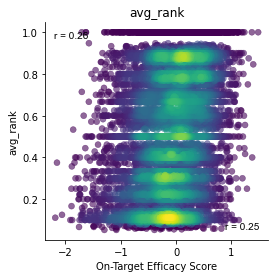

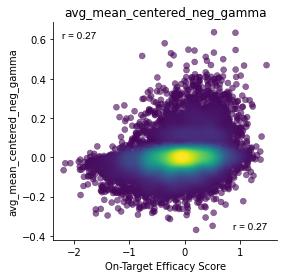

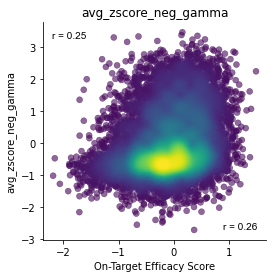

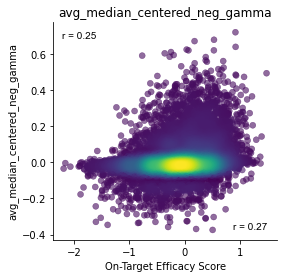

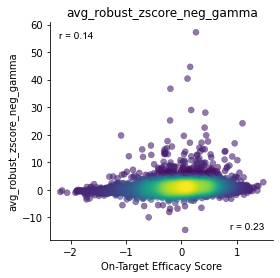

In [30]:
for score in ['avg_gamma','avg_rank', 'avg_mean_centered_neg_gamma', 'avg_zscore_neg_gamma',
              'avg_median_centered_neg_gamma', 'avg_robust_zscore_neg_gamma']:
    plt.subplots(figsize=(4,4))
    gpplot.point_densityplot(data=sg_avg_rank[[score, 'On-Target Efficacy Score']].dropna(),
                             y=score, x='On-Target Efficacy Score')
    gpplot.add_correlation(data=sg_avg_rank[[score, 'On-Target Efficacy Score']].dropna(),
                           y=score, x='On-Target Efficacy Score')
    gpplot.add_correlation(data=sg_avg_rank[[score, 'On-Target Efficacy Score']].dropna(),
                           y=score, x='On-Target Efficacy Score', method='spearman', loc='lower right')
    plt.title(score)
    sns.despine()

In [31]:
gilbert_lfcs_designs.to_csv('../data/gilbert_2014/gilbert2014_condition_lfcs.csv', index=False)
sg_avg_rank.to_csv('../data/gilbert_2014/gilbert2014_activity.csv', index=False)

In [32]:
sg_avg_rank

,sgRNA Sequence,sgRNA Context Sequence,Target Gene Symbol,On-Target Efficacy Score,sgRNA 'Cut' Site TSS Offset,DHS Score,Off-Target Rank,Pick Order,avg_rank,avg_mean_centered_neg_gamma,avg_zscore_neg_gamma,avg_median_centered_neg_gamma,avg_robust_zscore_neg_gamma,avg_gamma
0,AAAAACCGTCAGTAACACCG,ACAGAAAAACCGTCAGTAACACCGAGGACA,DPH5,0.22540,281,1.0,14,26.0,0.800000,0.006335,0.231827,0.010429,0.469227,-0.023441
1,AAAAAGGAGGTGTCCGGGTA,GAGGAAAAAGGAGGTGTCCGGGTAGGGCAA,NAA15,-0.12330,121,0.0,38,53.0,0.200000,-0.032686,-0.502020,-0.012122,-0.330041,0.011355
2,AAAAATGGCAGCCGCCGCTC,GCAGAAAAATGGCAGCCGCCGCTCCGGACT,RRP15,0.03283,36,1.0,35,3.0,1.000000,0.054083,2.379131,0.059402,3.813684,-0.068108
3,AAAAGCCGCAGGTAGGAGCA,CTCGAAAAGCCGCAGGTAGGAGCAAGGATC,RPAP2,0.08538,93,0.0,72,12.0,0.300000,-0.212684,-0.886969,-0.093857,-0.217992,-0.001776
4,AAAAGGGGCGCGGTGAGCTA,CTGGAAAAGGGGCGCGGTGAGCTAGGGCGG,CSNK1A1,0.65740,155,0.0,19,36.0,0.555556,-0.016589,-0.397251,0.000000,0.000000,-0.007086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10596,TTTGGGGAGCGCTGGGGTTG,GGCGTTTGGGGAGCGCTGGGGTTGTGGTGG,TNPO1,-0.42880,139,1.0,55,58.0,0.900000,0.010758,1.017886,0.008721,0.625740,-0.015120
10597,TTTGGTCCTTTCCGGGCGCG,GCGGTTTGGTCCTTTCCGGGCGCGCGGGGG,UPF1,-1.12300,170,1.0,14,62.0,0.500000,-0.003115,-0.255246,-0.000738,-0.071326,-0.000822
10598,TTTGGTGTTCCTGTGAACGT,GACGTTTGGTGTTCCTGTGAACGTGGGGCG,RIC8A,-0.06423,-32,0.0,11,38.0,0.666667,0.001184,0.106694,0.003264,0.398818,-0.004227
10599,TTTGTTTCCGGCGTGGGTCC,TGCGTTTGTTTCCGGCGTGGGTCCGGGCAA,CLP1,-0.41000,13,0.0,5,11.0,0.600000,-0.012396,-0.164703,0.006876,0.438869,-0.014314


In [40]:
import scipy
filtered_sgs['gene_mean_centered'] = (filtered_sgs.groupby(['Target Gene Symbol', 'condition'])['Growth phenotype (gamma)']
                                      .transform(lambda x: -(x - x.mean())))
filtered_sgs['gene_rank'] = (filtered_sgs.groupby(['Target Gene Symbol', 'condition'])['Growth phenotype (gamma)']
                             .rank(pct=True, ascending=False))

filtered_sgs['gene_zscore'] = (filtered_sgs.groupby(['Target Gene Symbol', 'condition'])['Growth phenotype (gamma)']
                               .transform(lambda x: -(x - x.mean())/x.std()))
filtered_sgs['gene_median_centered'] = (filtered_sgs.groupby(['Target Gene Symbol', 'condition'])['Growth phenotype (gamma)']
                                        .transform(lambda x: -(x - x.median())))
filtered_sgs['gene_robust_zscore'] = (filtered_sgs.groupby(['Target Gene Symbol', 'condition'])['Growth phenotype (gamma)']
                                      .transform(lambda x: -(x - x.median())/(x.quantile(0.75) - x.quantile(0.25))))
filtered_sgs['gene_just_zscore'] = (filtered_sgs['Growth phenotype (gamma)']
                               .transform(lambda x: scipy.stats.zscore(x)))
sg_avg_rank = (filtered_sgs.groupby(['sgRNA Sequence', 'sgRNA Context Sequence', 'Target Gene Symbol', 
                                      'On-Target Efficacy Score', 'sgRNA \'Cut\' Site TSS Offset',
                                    'DHS Score','Off-Target Rank','Pick Order'])
               .agg(avg_rank = ('gene_rank', 'mean'),
                    avg_mean_centered_neg_gamma = ('gene_mean_centered', 'mean'),
                    avg_zscore_gamma = ('gene_mean_centered', 'mean'),
                    avg_zscore_neg_gamma = ('gene_zscore', 'mean'),
                    avg_median_centered_neg_gamma = ('gene_median_centered', 'mean'),
                    avg_robust_zscore_neg_gamma = ('gene_robust_zscore', 'mean'),
                    avg_gamma = ('Growth phenotype (gamma)', 'mean'),
                   avg_z_score_without_anythong = ('gene_just_zscore', 'mean'))
                   
               .reset_index())

In [35]:
filtered_sgs.groupby(['Target Gene Symbol', 'condition'])

In [39]:
filtered_sgs['condition'].value_counts()

K562    11122
Name: condition, dtype: int64

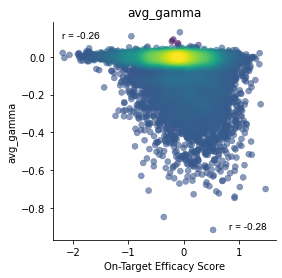

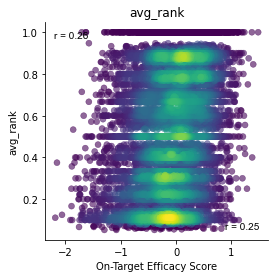

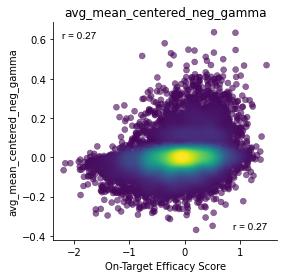

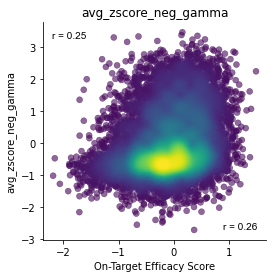

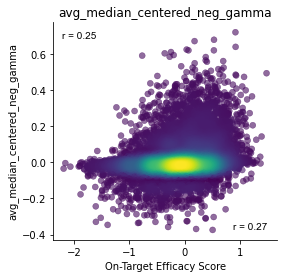

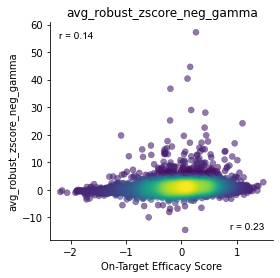

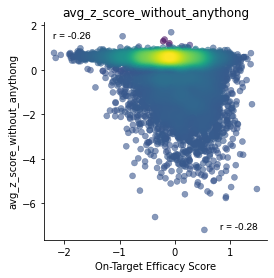

In [41]:
for score in ['avg_gamma','avg_rank', 'avg_mean_centered_neg_gamma', 'avg_zscore_neg_gamma',
              'avg_median_centered_neg_gamma', 'avg_robust_zscore_neg_gamma','avg_z_score_without_anythong']:
    plt.subplots(figsize=(4,4))
    gpplot.point_densityplot(data=sg_avg_rank[[score, 'On-Target Efficacy Score']].dropna(),
                             y=score, x='On-Target Efficacy Score')
    gpplot.add_correlation(data=sg_avg_rank[[score, 'On-Target Efficacy Score']].dropna(),
                           y=score, x='On-Target Efficacy Score')
    gpplot.add_correlation(data=sg_avg_rank[[score, 'On-Target Efficacy Score']].dropna(),
                           y=score, x='On-Target Efficacy Score', method='spearman', loc='lower right')
    plt.title(score)
    sns.despine()

<AxesSubplot:xlabel='avg_gamma', ylabel='avg_z_score_without_anythong'>

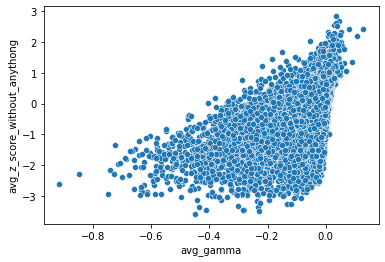

In [34]:
sns.scatterplot(data = sg_avg_rank, x = 'avg_gamma', y = 'avg_z_score_without_anythong')